In [1]:
#Tratamiento de datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forescasting
from lightgbm import LGBMRegressor    #Regressor mas potente de gradient bossting
from skforecast.ForecasterAutoreg import ForecasterAutoreg  # Modelo autoregressivo
from skforecast.model_selection import grid_search_forecaster # Encontrar los mejores hiperparametros(optimizar el modelo)
from skforecast.model_selection import backtesting_forecaster  # Evaluar el modelo si hubiese estado en produccion

#Configuration warning
import warnings
warnings.filterwarnings('ignore')

c:\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATOS  
Los datos recolectados se han obtenido del paquete de R  

In [2]:
#Descarga de datos
datos = pd.read_csv('vic_elec.csv')

In [3]:
len(datos)

52608

In [4]:
datos.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [5]:
#Conversion del formato fecha
# Convertimos la columna de Time en un formato DateTime  de "Y/M/D H-M-S"
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
#Se establece la columna 'Time' como el índice del DataFrame "datos"
datos = datos.set_index('Time')

#Ajustar la frecuencia de los datos a 30min; Por ejemplo, si
# originalmente tenías datos en intervalos de una hora, esta línea podría agregar filas adicionales para cada 30 minutos 
datos = datos.asfreq('30min') 

# Ordenar los index, garantiza que los datos estén ordenados cronológicamente en función de la columna de tiempo.
datos = datos.sort_index()

In [6]:
datos

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


In [7]:
#Agregado en intervalos de 1 hora
#Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es boolena y se trata como 0-1
datos =  datos.drop(columns='Date')

#Resample se utiliza para cambiar la frecuencia de los datos en una serie temporal. 
# En este caso, estás cambiando la frecuencia de los datos a horas ('H') y calculando la media en cada intervalo de hora.
datos = datos.resample(rule='H', closed='left',label = 'right').mean()

In [8]:
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [9]:
#Creacion de una variable que indique si es fin de semana 
#Se utiliza el Index del DataFrame para acceder al índice, y luego dayofweek devuelve
#  un valor numérico donde 0 representa el lunes, 1 representa el martes y así sucesivamente
datos['dia_semana'] = datos.index.dayofweek

#get_dummies de pandas para convertir la columna 'dia_semana' en variables ficticias (o "dummy variables") 
datos = pd.get_dummies(datos,columns=['dia_semana'], dtype=int)

In [10]:
datos

,Demand,Temperature,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
Time,,,,,,,,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0,0,0,0,0,0,1,0
2011-12-31 15:00:00,3963.264688,20.625,1.0,0,0,0,0,0,1,0
2011-12-31 16:00:00,3950.913495,20.325,1.0,0,0,0,0,0,1,0
2011-12-31 17:00:00,3627.860675,19.850,1.0,0,0,0,0,0,1,0
2011-12-31 18:00:00,3396.251676,19.025,1.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0,0,0,1,0,0,0,0
2014-12-31 10:00:00,3909.230704,20.300,0.0,0,0,1,0,0,0,0
2014-12-31 11:00:00,3900.600901,19.650,0.0,0,0,1,0,0,0,0


In [11]:
datos.loc['2013-12-31 23:00:00']

Demand          3467.062077
Temperature       22.350000
Holiday            1.000000
dia_semana_0       0.000000
dia_semana_1       1.000000
dia_semana_2       0.000000
dia_semana_3       0.000000
dia_semana_4       0.000000
dia_semana_5       0.000000
dia_semana_6       0.000000
Name: 2013-12-31 23:00:00, dtype: float64

In [12]:
#Separacion de los datos en Train-Validation-Test
datos = datos.loc['2013-01-01 00:00:00' : '2014-03-31 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-02-28 23:59:00'
datos_train = datos.loc[:fin_train, :] #Un año
datos_val = datos.loc[fin_train:fin_validacion, :] #2 meses
datos_test = datos.loc[fin_validacion: , :] # 3 meses

print(f"Fechas train: {datos_train.index.min()} ... {datos_train.index.max()} (n={len(datos_train)})")
print(f"Fechas validacion: {datos_val.index.min()} ... {datos_val.index.max()} (n={len(datos_val)})")
print(f"Fechas test: {datos_test.index.min()} ... {datos_test.index.max()} (n={len(datos_test)})")

Fechas train: 2013-01-01 00:00:00 ... 2013-12-31 23:00:00 (n=8760)
Fechas validacion: 2014-01-01 00:00:00 ... 2014-02-28 23:00:00 (n=1416)
Fechas test: 2014-03-01 00:00:00 ... 2014-03-31 23:00:00 (n=744)


In [13]:
 print(datos_train.shape,datos_val.shape, datos_test.shape)

(8760, 10) (1416, 10) (744, 10)


Exploracion Grafica

In [14]:
datos

,Demand,Temperature,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
Time,,,,,,,,,,
2013-01-01 00:00:00,3512.338934,19.00,1.0,0,1,0,0,0,0,0
2013-01-01 01:00:00,3660.994982,20.85,1.0,0,1,0,0,0,0,0
2013-01-01 02:00:00,3753.045819,21.95,1.0,0,1,0,0,0,0,0
2013-01-01 03:00:00,3796.618496,22.65,1.0,0,1,0,0,0,0,0
2013-01-01 04:00:00,3830.588959,23.65,1.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2014-03-31 19:00:00,3766.133212,22.35,0.0,1,0,0,0,0,0,0
2014-03-31 20:00:00,4397.206925,22.25,0.0,1,0,0,0,0,0,0
2014-03-31 21:00:00,5219.162744,21.95,0.0,1,0,0,0,0,0,0


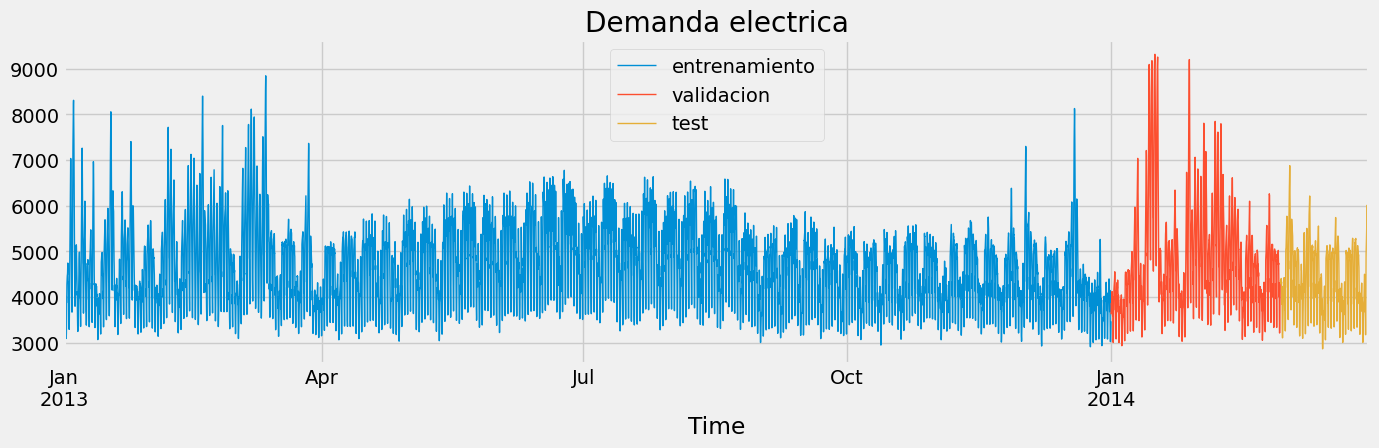

In [15]:
#Grafico de la serie temporal

#crea una nueva figura y un par de ejes (axes) dentro de la figura
fig, ax = plt.subplots(figsize=(15,4)) # figsize=(15,4) establece el tamaño de la figura en 15 unidades de ancho y 4 unidades de alto.

#Las series se colorean automáticamente según una paleta de colores predefinida por matplotlib
datos_train.Demand.plot(ax=ax, label="entrenamiento", linewidth=1)
datos_val.Demand.plot(ax=ax, label="validacion", linewidth=1)
datos_test.Demand.plot(ax=ax, label="test", linewidth=1)
ax.set_title('Demanda electrica')
ax.legend();

In [16]:
datos

,Demand,Temperature,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
Time,,,,,,,,,,
2013-01-01 00:00:00,3512.338934,19.00,1.0,0,1,0,0,0,0,0
2013-01-01 01:00:00,3660.994982,20.85,1.0,0,1,0,0,0,0,0
2013-01-01 02:00:00,3753.045819,21.95,1.0,0,1,0,0,0,0,0
2013-01-01 03:00:00,3796.618496,22.65,1.0,0,1,0,0,0,0,0
2013-01-01 04:00:00,3830.588959,23.65,1.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2014-03-31 19:00:00,3766.133212,22.35,0.0,1,0,0,0,0,0,0
2014-03-31 20:00:00,4397.206925,22.25,0.0,1,0,0,0,0,0,0
2014-03-31 21:00:00,5219.162744,21.95,0.0,1,0,0,0,0,0,0


In [17]:
# Grafico Interactivo de la Serie Temporal

#Crea la columna de partition, con train, validation, test
datos.loc[:fin_train, 'partition'] = 'train'
datos.loc[fin_train:fin_validacion, 'partition'] = 'validation'
datos.loc[fin_validacion:, 'partition'] = 'test'

fig = px.line(
    data_frame = datos.reset_index(),
    x = 'Time',
    y = 'Demand',
    color = 'partition',
    title = 'Number of users',
    width = 1200,
    height = 500
)

fig.show()
datos=datos.drop(columns='partition')

Grafico de Autocorrelacion 

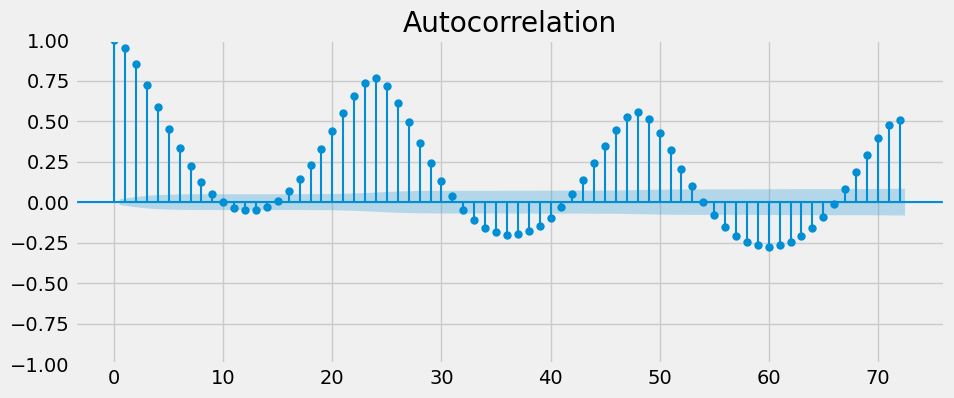

In [18]:
#Grafico autocorrelación

#Crea una figura y un conjunto de ejes (ax)
fig, ax = plt.subplots(figsize=(10,4))

#Aquí utilizamos la función plot_acf para trazar la función de autocorrelación
#ax=ax indica que el gráfico se dibujará en los ejes que has creado anteriormente. 
# lags=72 define el número máximo de intervalos de tiempo pasados que se considerarán al calcular la función de autocorrelación. 
plot_acf(datos.Demand, ax=ax, lags=72)
plt.show()

#Podemos ver que la correlacion de la prediccion esta altamente correlaciona con el la demanda en el dia anterior a la misma hora.

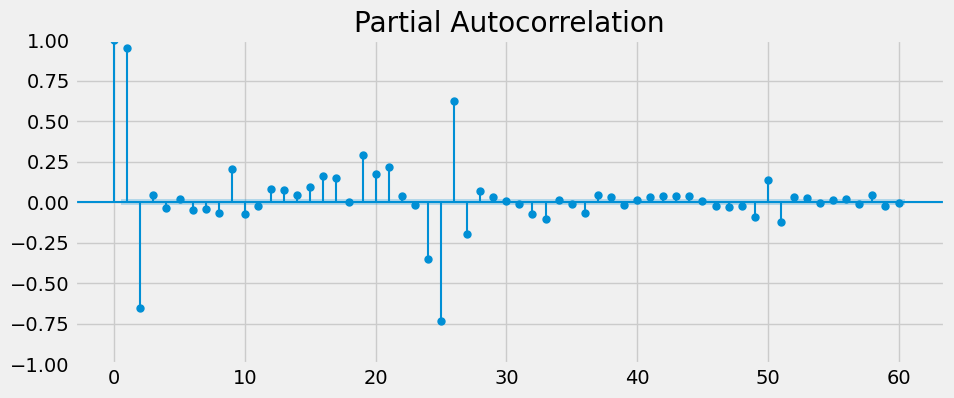

In [19]:
#Grafico de Autocorrelacion parcial
fig, ax = plt.subplots(figsize=(10,4))

#plot_pacf para trazar la función de autocorrelación parcial
plot_pacf(datos.Demand, ax=ax, lags=60)

# PACF muestra la correlación directa entre la serie y sus 
# valores anteriores hasta 60 intervalos de tiempo atrás, teniendo en cuenta las correlaciones indirecta
plt.show()

Dias festivos vs laborales

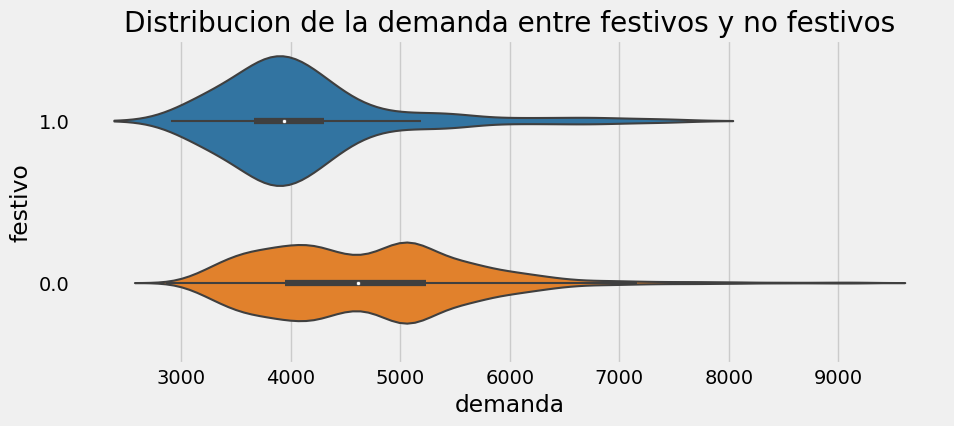

In [20]:
# Grafico violinplot
fig, ax = plt.subplots(figsize=(10,4))
sns.violinplot(
    x = 'Demand',
    y = 'Holiday', # y='Holiday': Los valores de la columna 'Holiday' (festivo) se utilizarán para separar las categorías en el eje y.
    data = datos.assign(Holiday = datos.Holiday.astype(str)), #Se utiliza la serie de datos 'datos', y la columna 'Holiday' se convierte a tipo de dato string
    palette = 'tab10',
    ax = ax
)
ax.set_title('Distribucion de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

#En conclusion se diria que existe una diferencia en la demanda de consumo, de los dias festivos vs dias no festivos

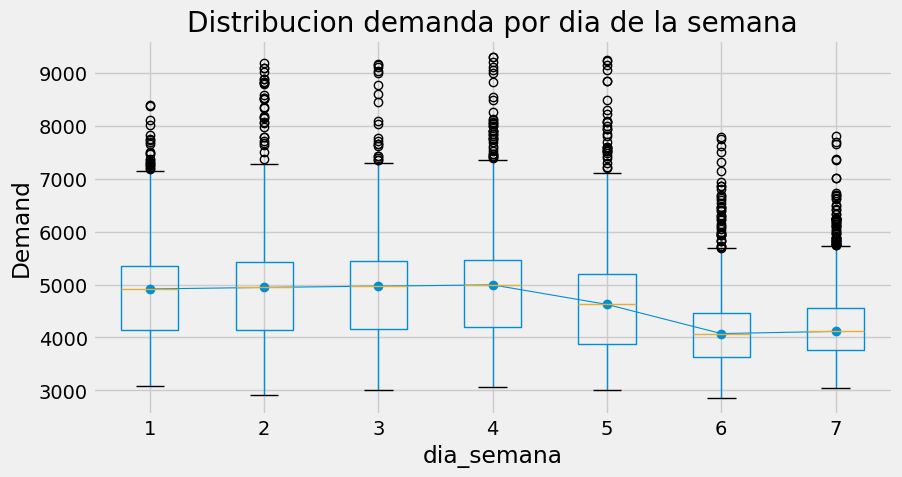

In [21]:
#Grafico boxplot para estacionalidad semanal
fig, ax = plt.subplots(figsize=(10,5))

#Se agrega una nueva columna 'dia_semana' a los datos, que contiene el día de la semana correspondiente a cada fecha en la serie de datos. 
# day_of_week devuelve el día de la semana como un número 
# (0 para lunes, 1 para martes, y así sucesivamente), por lo que se suma 1 para que los días de la semana se representen del 1 al 7
datos['dia_semana'] = datos.index.day_of_week + 1

#El argumento by='dia_semana' agrupa los datos por el valor en la columna 'dia_semana'.
datos.boxplot(column='Demand', by='dia_semana', ax=ax)

#Aquí, estás calculando las medianas de la demanda para cada día de la semana utilizando groupby y 
# luego trazando estas medianas en el gráfico de cajas como un gráfico de líneas con círculos marcados
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribucion demanda por dia de la semana')
fig.suptitle('');


Entrenamiento del Forescaster

In [22]:
#Crear  y entrenar forescaster
forescaster = ForecasterAutoreg(
    regressor=LGBMRegressor(max_depth=3, learning_rate=0.1, n_estimators=70),
    lags= 24 #[1, 2, 3, 24]
)
forescaster #forescaster.summary()

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3, n_estimators=70) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 70, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2023-08-31 13:53:30 
Last fit date: None 
Skforecast version: 0.9.1 
Python version: 3.11.2 
Forec

Entrenamiento del Forescaster

In [23]:
forescaster.fit(y=datos.loc[:fin_validacion, 'Demand']) #Entrenamiento con conjuntos de train + validacion
forescaster

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 10152, number of used features: 24
[LightGBM] [Info] Start training from score 4676.230930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3, n_estimators=70) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 70, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2023-08-31 13:53:30 
Last fi

Predicciones 

In [24]:
predicciones = forescaster.predict(steps=40)
predicciones

2014-03-01 00:00:00    4319.494278
2014-03-01 01:00:00    4373.029749
2014-03-01 02:00:00    4324.737882
2014-03-01 03:00:00    4323.433876
2014-03-01 04:00:00    4323.433876
2014-03-01 05:00:00    4412.247747
2014-03-01 06:00:00    4488.586431
2014-03-01 07:00:00    4589.883140
2014-03-01 08:00:00    4657.400213
2014-03-01 09:00:00    4616.447961
2014-03-01 10:00:00    4579.776120
2014-03-01 11:00:00    4420.800423
2014-03-01 12:00:00    4197.853612
2014-03-01 13:00:00    4040.574672
2014-03-01 14:00:00    4097.804564
2014-03-01 15:00:00    3820.530387
2014-03-01 16:00:00    3569.046337
2014-03-01 17:00:00    3442.233520
2014-03-01 18:00:00    3366.331402
2014-03-01 19:00:00    3438.254418
2014-03-01 20:00:00    3706.734455
2014-03-01 21:00:00    3933.976452
2014-03-01 22:00:00    4104.783726
2014-03-01 23:00:00    4167.059945
2014-03-02 00:00:00    4114.606365
2014-03-02 01:00:00    4100.474986
2014-03-02 02:00:00    4105.341126
2014-03-02 03:00:00    4105.341126
2014-03-02 04:00:00 

In [25]:
# Interactive plot of predictions
datos_plot = pd.DataFrame({
                'test':datos_test['Demand'],
                'prediction':predicciones,

})
datos_plot.index.name= 'Time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x = 'Time',
    y = datos_plot.columns,
    title = 'Demanda Electrica',
    width = 1200,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()


Backtesting

Se evalua el comportamiento que habria tenido el modelo si hubiese  entrenado con los datos de TRAIN, y despues de las 
23:59 de cada dia, se predijieran las 24 horas siguientes. A este tipo de evaluacion se le conoce como BACKTESTING, y puede aplicarse
facilmente con la funcion backtesting_forescaster(). Esta funcion devuelve,ademas de las predicciones, una metrica de error.

In [26]:
datos['Demand']

Time
2013-01-01 00:00:00    3512.338934
2013-01-01 01:00:00    3660.994982
2013-01-01 02:00:00    3753.045819
2013-01-01 03:00:00    3796.618496
2013-01-01 04:00:00    3830.588959
                          ...     
2014-03-31 19:00:00    3766.133212
2014-03-31 20:00:00    4397.206925
2014-03-31 21:00:00    5219.162744
2014-03-31 22:00:00    5323.944599
2014-03-31 23:00:00    5481.478056
Freq: H, Name: Demand, Length: 10920, dtype: float64

In [27]:
len(datos.loc[:fin_validacion])

10176

In [28]:
#Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster= forescaster,
                            y= datos['Demand'], # Total de datos 
                            initial_train_size= len(datos.loc[:fin_validacion]), # datos para train
                            steps=24,
                            metric='mean_absolute_error',
                            refit=False,
                            verbose=True

)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 10152, number of used features: 24
[LightGBM] [Info] Start training from score 4676.230930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10176
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-01-01 0

100%|██████████| 31/31 [00:00<00:00, 57.77it/s]


In [29]:
print(f"Backtest error: {metrica}")

Backtest error: 319.35785733557003


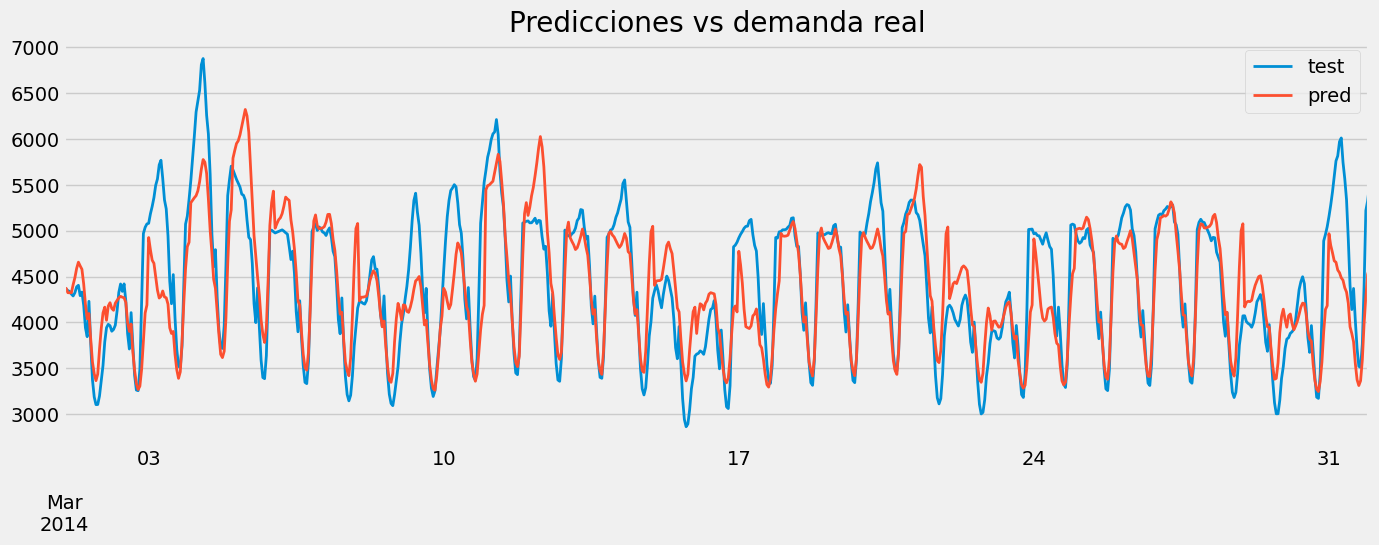

In [30]:
#Grafico
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicciones', ax=ax)
ax.set_title('Predicciones vs demanda real')
ax.legend();

In [31]:
#Grafico Interactivo de las predicciones
datos_plot = pd.DataFrame({
                'test': datos_test['Demand'],
                'prediction': predicciones['pred'],
            }) 

datos_plot.index.name = 'Time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x = 'Time',
    y = datos_plot.columns,
    title = 'Demanda Electrica',
    width = 1200,
    height=500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

Intervalos de predicción (Opcional)

In [32]:
# Calcular percentiles
percentil_5 = datos['Demand'].quantile(0.05)
percentil_95 = datos['Demand'].quantile(0.95)

# Calcular el primer cuartil (percentil 25)
#primer_cuartil = datos['Demand'].quantile(0.25)

# Calcular el tercer cuartil (percentil 75)
#tercer_cuartil = datos['Demand'].quantile(0.75)

print("Percentil 5:", percentil_5)
print("Percentil 95:", percentil_95)

Percentil 5: 3363.7022475999997
Percentil 95: 6219.631811899998


In [ ]:
#Backtest con intervalos de predicción
metrica, predicciones = backtesting_forecaster(
                        forecaster= forescaster,
                        y = datos['Demand'],
                        initial_train_size=len(datos.loc[:fin_validacion]),# El tamaño del conjunto de entrenamiento inicial, 
                        #que esta definido como la longitud de los datos total hasta el punto de validación final 
                        steps = 24,
                        #Al usar el percentil 5 y el percentil 95, se está creando un intervalo de confianza del 90% alrededor de las
                        #  predicciones del modelo.Esto significa que hay una probabilidad del 90% de que el valor real se encuentre 
                        # dentro de este intervalo, lo que proporciona una medida de la incertidumbre
                        interval = [5, 95], #Intervalo del 90% (entre percentil 5 y 95)
                        #Puedes decir que con un 90% de confianza (90% probabilidad), esperas que la demanda eléctrica real en las próxima hora
                        # caiga dentro del rango de 900 MW (límite inferior) a 1100 MW (límite superior).
                        n_boot = 100,
                        metric = 'mean_absolute_error',
                        refit = False,
                        verbose = False
)
predicciones.head()

In [ ]:
#Grafico: el código genera un gráfico que muestra las series de datos reales de demanda eléctrica, 
# las predicciones del modelo y el intervalo de confianza alrededor de estas predicciones.
fig, ax = plt.subplots(figsize=(15,5))

#Se traza la serie de datos reales de demanda eléctrica del conjunto de pruebas (test) en el gráfico. Utiliza la columna 'Demand' 
# del DataFrame 'datos' y la función .plot() para visualizar estos datos en los ejes 'ax'
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')

#Se traza la serie de predicciones generadas por el modelo en el gráfico.
predicciones['pred'].plot(ax=ax, label='predicciones')

#La función fill_between() toma tres argumentos: los índices de tiempo (fechas) de las predicciones, los valores del límite 
#inferior y los valores del límite superior. Esto crea una región sombreada en el gráfico para visualizar el intervalo de confianza. 
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color='red',
    alpha=0.2

)
ax.legend();

Ajuste de Hiperparametros (Tuning)

Es importante que, en la busqueda de hiperparametros, no se utilicen los datos de test, de lo contrario podrian aparecer problemas
de overfitting(sobreajuste-el modelo no puede generalizar) del modelo. Con este objetivo, se realiza una busqueda en la que, con cada
combinacion de hiperparametros y lags(pasos en la serie temporal): 
1) Se entrena el modelo con los datos de entrenamiento
2) Se evalua el modelo con los datos de validacion mediante backtesting sin entrenamiento (Validacion)
3) Se identifica la combinacion de hiperparametros y lags con los que se consigue menor error
4) Se entrena el modelo con la mejor combinacion encontrada, esta vez con Datos train + Datos Validacion


In [33]:
#Grid search de hiperparametros 
# Para hacer el grid search, se utilizara solo TRAIN + VALIDACION(simulando la data total), y  TRAIN (entrenamiento), y sacar el mejore modelo
# Luego cuando se haga denuevo el backtesting, se usa total de datos , y validacion (para entrenamiento)
#Hiperparametros del regresor

param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizamos como predictores
lags_grid = [24, 48, [1,2,24]]

resultados_grid = grid_search_forecaster(
            forecaster = forescaster,
            y = datos.loc[:fin_validacion, 'Demand'], # conjunto de train + validacion (datos de la variable objetivo)
            param_grid = param_grid,
            steps = 24,
            refit = False,
            metric= 'mean_absolute_error',
            initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
            return_best = True,  # Reentrenara el modelo para que ya el modelo tenga los hiperparametros optimos
            verbose = False

)


Number of models compared: 8.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 24
[LightGBM] [Info] Start training from score 4652.337038


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 24
[LightGBM] [Info] Start training from score 4652.337038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 24
[LightGBM] [Info] Start training from score 4652.337038
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 24
[LightGBM] [Info] Start training from score 4652.337038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 24
[LightGBM] [Info] Start training from score 4652.337038
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

lags grid: 100%|██████████| 1/1 [00:08<00:00,  8.76s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [34]:
#Resultados de Grid Search
resultados_grid.head(20)

,lags,params,mean_absolute_error,learning_rate,max_depth,max_iter
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",429.570378,0.10,10.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",435.108022,0.10,10.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",445.707094,0.10,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",472.088451,0.01,10.0,500.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",504.206902,0.10,3.0,100.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",540.256443,0.01,3.0,500.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",755.513369,0.01,10.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",771.016617,0.01,3.0,100.0


In [35]:
#Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster= forescaster,
                            y= datos['Demand'], # Total de datos 
                            initial_train_size= len(datos.loc[:fin_validacion]), # datos para train
                            steps=24,
                            metric='mean_absolute_error',
                            refit=False,
                            verbose=True

)
print(f"Backtest error: {metrica}")

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 10152, number of used features: 24
[LightGBM] [Info] Start training from score 4676.230930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

 48%|████▊     | 15/31 [00:00<00:00, 75.01it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

 74%|███████▍  | 23/31 [00:00<00:00, 71.79it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

100%|██████████| 31/31 [00:00<00:00, 70.71it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

#### Incluir variables exógenas  
##### Se repite el proceso pero, esta vez incluyendo como variables exogenas el dia de la semana y si es festivo o laboral

In [36]:
#Crear y entrenar el Forescaster
forecaster = ForecasterAutoreg(
                regressor= LGBMRegressor(max_depth=3, learning_rate=0.1, n_estimators=100),
                lags = 48,
)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2023-08-31 13:54:55 
Last fit date: None 

In [37]:
variables_exog = ['Holiday', 'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5',
                  'dia_semana_6']

#Entrenamiento del forecaster, con los datos TRAIN + VALIDACION ( Las variables exogenas ingresan para entrenar el modelo forecaster)
forecaster.fit(
        y = datos.loc[:fin_validacion, 'Demand'],
        exog = datos.loc[:fin_validacion, variables_exog]
) 

forecaster



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12256
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 56
[LightGBM] [Info] Start training from score 4677.478507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Holiday', 'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5', 'dia_semana_6'] 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31

In [38]:
# Los valores de 24 horas de las variables exogenas, predeciran ahora cual seria la variable y ('Demanda Electrica')
datos_test[variables_exog][:24]

,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
Time,,,,,,,,
2014-03-01 00:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 01:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 02:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 03:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 04:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 05:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 06:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 07:00:00,0.0,0,0,0,0,0,1,0
2014-03-01 08:00:00,0.0,0,0,0,0,0,1,0


In [39]:
# Prediccion
exog_siguientes_24h = datos_test[variables_exog][:24] # 24 horas posteriores de las variables exogenas (ya se conocen)

predicciones = forecaster.predict(steps=24, exog=exog_siguientes_24h) # predicciones la demanda electrica de esas 24 horas posteriores
predicciones

2014-03-01 00:00:00    4238.149846
2014-03-01 01:00:00    4141.410349
2014-03-01 02:00:00    4147.053766
2014-03-01 03:00:00    4155.961236
2014-03-01 04:00:00    4161.567688
2014-03-01 05:00:00    4217.229606
2014-03-01 06:00:00    4249.459319
2014-03-01 07:00:00    4320.135076
2014-03-01 08:00:00    4340.551153
2014-03-01 09:00:00    4322.603226
2014-03-01 10:00:00    4296.062395
2014-03-01 11:00:00    4184.889618
2014-03-01 12:00:00    3992.374920
2014-03-01 13:00:00    3930.737112
2014-03-01 14:00:00    4111.287856
2014-03-01 15:00:00    3698.420407
2014-03-01 16:00:00    3389.286929
2014-03-01 17:00:00    3213.918409
2014-03-01 18:00:00    3130.620720
2014-03-01 19:00:00    3178.238106
2014-03-01 20:00:00    3308.564656
2014-03-01 21:00:00    3497.072232
2014-03-01 22:00:00    3753.878814
2014-03-01 23:00:00    3902.437299
Freq: H, Name: pred, dtype: float64

In [40]:
#Backtest
metrica, predicciones = backtesting_forecaster(
                            forecaster= forecaster,
                            y= datos['Demand'], # Total de datos 
                            exog = datos[variables_exog],
                            initial_train_size= len(datos.loc[:fin_validacion]), # datos para train (TRAIN+VALIDACION)
                            steps=24,  #Lags a predecir en el proceso iterarivo de Backtesting
                            metric='mean_absolute_error', 
                            refit=False,
                            verbose=True
)
print(f"Backtest error: {metrica}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12256
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 56
[LightGBM] [Info] Start training from score 4677.478507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

100%|██████████| 31/31 [00:00<00:00, 73.08it/s]

Backtest error: 196.3384637226096


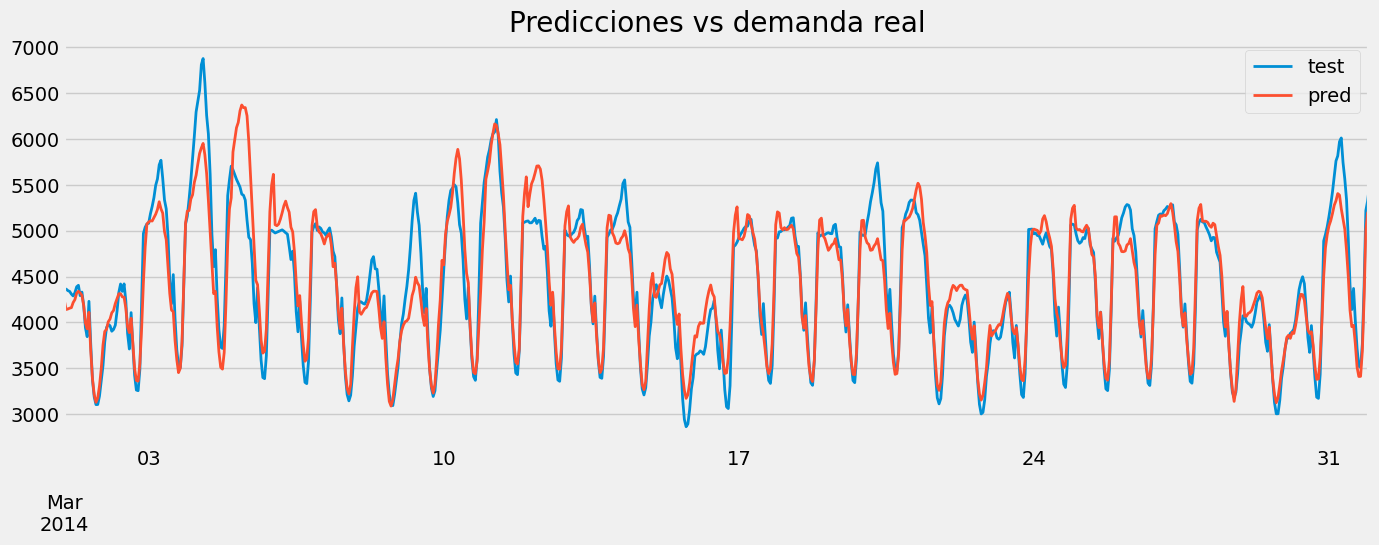

In [41]:
#Grafico
fig, ax = plt.subplots(figsize=(15, 5))

datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='prediccion', ax=ax)
ax.set_title('Predicciones vs demanda real')
ax.legend();

Importancia de los predictores

In [42]:
forecaster.get_feature_importances().sort_values('importance', ascending=False)

,feature,importance
0,lag_1,190
25,lag_26,59
23,lag_24,48
22,lag_23,35
24,lag_25,33
26,lag_27,29
21,lag_22,19
27,lag_28,17
19,lag_20,15
46,lag_47,15


## Modelos de Forescasting en producción

In [43]:
#Entrenamos el modelo de Forecaster, solo con la columna DEMAND, sin variables exogenas. (Como ejemplo)
forecaster.fit(y = datos.loc[:fin_validacion, 'Demand'])
forecaster

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 48
[LightGBM] [Info] Start training from score 4677.478507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fi

In [44]:
#Predicciones seguidas de los datos utilizados para entrenar el modelo
predicciones = forecaster.predict(steps=24)
predicciones

2014-03-01 00:00:00    4271.184315
2014-03-01 01:00:00    4236.559389
2014-03-01 02:00:00    4210.816789
2014-03-01 03:00:00    4207.133741
2014-03-01 04:00:00    4226.487069
2014-03-01 05:00:00    4272.631719
2014-03-01 06:00:00    4334.939937
2014-03-01 07:00:00    4387.448298
2014-03-01 08:00:00    4424.427617
2014-03-01 09:00:00    4399.800912
2014-03-01 10:00:00    4357.976013
2014-03-01 11:00:00    4285.078392
2014-03-01 12:00:00    4036.788082
2014-03-01 13:00:00    3958.934952
2014-03-01 14:00:00    4140.638641
2014-03-01 15:00:00    3778.606255
2014-03-01 16:00:00    3500.937284
2014-03-01 17:00:00    3343.315215
2014-03-01 18:00:00    3283.826355
2014-03-01 19:00:00    3313.338593
2014-03-01 20:00:00    3529.961815
2014-03-01 21:00:00    3845.484072
2014-03-01 22:00:00    4212.155273
2014-03-01 23:00:00    4517.217360
Freq: H, Name: pred, dtype: float64

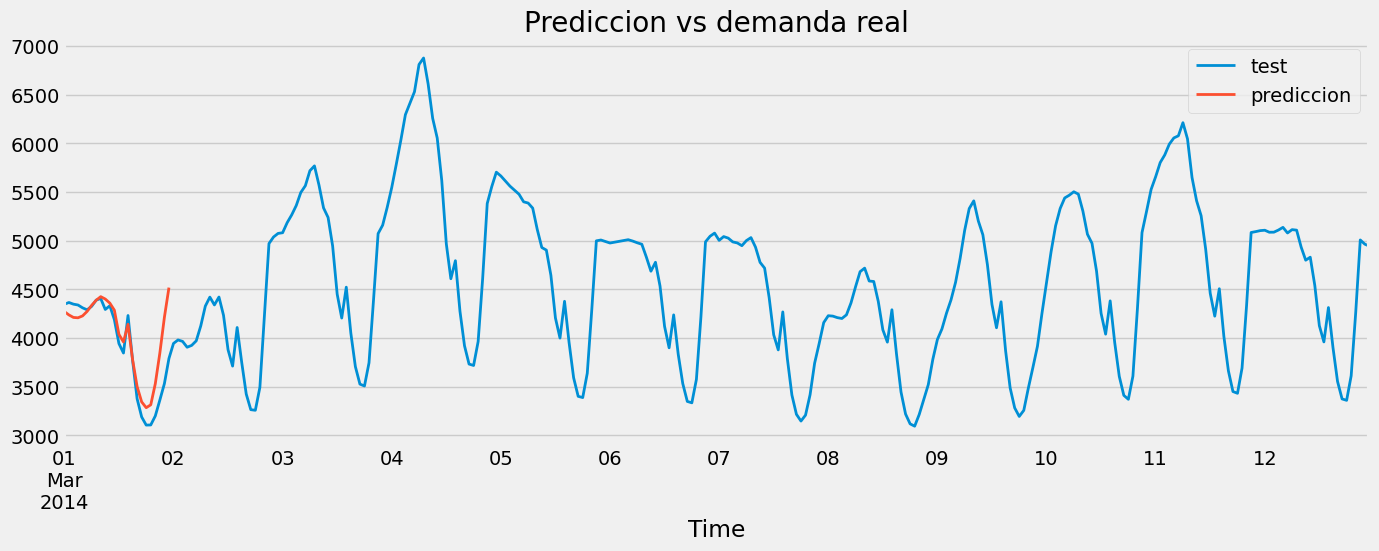

In [45]:
#Grafico de las predicciones (24 hrs)
fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2014-03-12 23:00:00', 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='prediccion', ax=ax)
ax.set_title('Prediccion vs demanda real')
ax.legend();

### Predicciones en un momento cualquiera

In [59]:
datos_ultimas_48h = datos.loc['2014-03-10 00:00:00': '2014-03-12 23:00:00', 'Demand']

predicciones = forecaster.predict(steps=24, last_window=datos_ultimas_48h) #24 horas adelante, apartir de la fecha que le damos '2014-03-12 23:00:00'
#OJO: El modelo Forecaster, ya tiene dentro la implementacion, solo estamos prediciendo, con un salto en el futuro
predicciones

2014-03-13 00:00:00    4913.571812
2014-03-13 01:00:00    4852.956669
2014-03-13 02:00:00    4871.831561
2014-03-13 03:00:00    4898.095692
2014-03-13 04:00:00    4914.254486
2014-03-13 05:00:00    4930.245702
2014-03-13 06:00:00    4987.416665
2014-03-13 07:00:00    5019.377381
2014-03-13 08:00:00    4890.698443
2014-03-13 09:00:00    4766.295588
2014-03-13 10:00:00    4744.723853
2014-03-13 11:00:00    4524.512730
2014-03-13 12:00:00    4196.198480
2014-03-13 13:00:00    3977.013843
2014-03-13 14:00:00    4178.377401
2014-03-13 15:00:00    3834.556278
2014-03-13 16:00:00    3568.704151
2014-03-13 17:00:00    3423.980979
2014-03-13 18:00:00    3413.833511
2014-03-13 19:00:00    3619.344606
2014-03-13 20:00:00    4212.082861
2014-03-13 21:00:00    4808.770757
2014-03-13 22:00:00    5112.249781
2014-03-13 23:00:00    5110.150579
Freq: H, Name: pred, dtype: float64

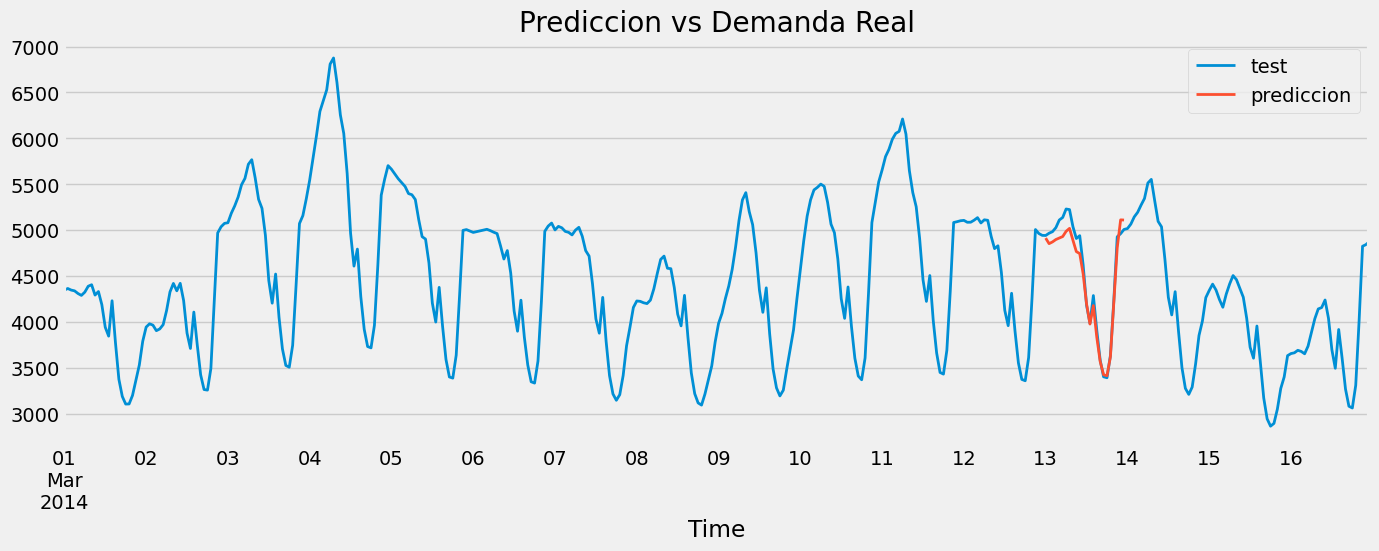

In [60]:
#Grafico
fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2014-03-16 23:00:00', 'Demand'].plot(ax=ax, linewidth=2, label = 'test')
predicciones.plot(linewidth=2, label='prediccion', ax=ax)
ax.set_title('Prediccion vs Demanda Real')
ax.legend();

In [61]:
import joblib

# Guardar el modelo en un archivo
nombre_archivo = 'modelo_forecaster.pkl'
joblib.dump(forecaster, nombre_archivo)


['modelo_forecaster.pkl']

## Otras funcionalidades del SKforecast

##### Predictores custom
##### Modelos direct multi-output
##### Diferentes estrategias de validacion
##### Exportacion de modelos